In [75]:
!date

Tue Jul 27 21:51:27 PDT 2021


# All clusters DE

In [76]:
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
import scanpy as sc
from scipy.stats import ks_2samp, ttest_ind
import ast
from scipy.sparse import csr_matrix
import warnings
warnings.filterwarnings('ignore')


import sys
sys.path.append('../../../../BYVSTZP_2020/dexpress')
from dexpress import dexpress, utils, plot

#sys.path.append('../../../BYVSTZP_2020/trackfig')
#from trackfig.utils import get_notebook_name
#from trackfig.trackfig import trackfig 

#TRACKFIG = "../../../BYVSTZP_2020/trackfig.txt"
#NB = get_notebook_name()

def yex(ax):
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    # now plot both limits against eachother
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    return ax

fsize=20

plt.rcParams.update({'font.size': fsize})
%config InlineBackend.figure_format = 'retina'

In [77]:
cluster_cmap = {
"Astro": (0.38823529411764707, 0.4745098039215686,  0.2235294117647059 ),  # 637939,
"Endo" : (0.5490196078431373,  0.6352941176470588,  0.3215686274509804 ),  # 8ca252,
"SMC"  : (0.7098039215686275,  0.8117647058823529,  0.4196078431372549 ),  # b5cf6b,
"VLMC" : (0.807843137254902,   0.8588235294117647,  0.611764705882353  ),  # cedb9c,
"Low Quality" : (0,0,0),
"L2/3 IT" : (0.9921568627450981,  0.6823529411764706,  0.4196078431372549  ),  # fdae6b
"L5 PT" : (0.9921568627450981,  0.8156862745098039,  0.6352941176470588  ),  # fdd0a2
"L5 IT" : (0.5176470588235295,  0.23529411764705882, 0.2235294117647059 ),  # 843c39
"L5/6 NP": "#D43F3A",
"L6 CT" : (0.8392156862745098,  0.3803921568627451,  0.4196078431372549 ),  # d6616b
"L6 IT" : (0.9058823529411765,  0.5882352941176471,  0.611764705882353  ),  # e7969c
"L6b" : (1.0,                 0.4980392156862745,  0.054901960784313725),  # ff7f0e
"L6 IT Car3" : (1.0,                 0.7333333333333333,  0.47058823529411764 ),  # ffbb78
"Lamp5" : (0.19215686274509805, 0.5098039215686274,  0.7411764705882353  ),  # 3182bd # blues
"Sncg" : (0.4196078431372549,  0.6823529411764706,  0.8392156862745098  ),  # 6baed6
"Vip" : (0.6196078431372549,  0.792156862745098,   0.8823529411764706  ),  # 9ecae1
"Sst" : (0.7764705882352941,  0.8588235294117647,  0.9372549019607843  ),  # c6dbef
"Pvalb":(0.7372549019607844,  0.7411764705882353,  0.8627450980392157  ),  # bcbddc
}

In [78]:
cluster_cmap = pd.read_csv('../../metadata_files/CTX_Hip_anno_SSv4.csv', index_col='cluster_label',usecols=['cluster_label','cluster_color'])
cluster_cmap = cluster_cmap.drop_duplicates()
cluster_cmap = cluster_cmap.cluster_color.apply(lambda x: mcolors.to_rgb(x) )
cluster_cmap = cluster_cmap.to_dict()

In [79]:
num_TSNE = 2
state = 42
metric = "euclidean"
n_neighbors = 30
num_PCA = 25
num_NCA = 10

# Filtering criteria
cell_threshold = 250
disp_threshold = 0.001

mito_criteria = 10

n_top_genes = 5000

n_bins = 20

flavor="seurat"

scale_clip = 10

In [80]:
import ast

In [81]:
gene = anndata.read_h5ad("../../../data/notebook/revision/gene.h5ad")
isoform = anndata.read_h5ad("../../../data/notebook/revision/isoform.h5ad")

In [82]:
isoform = isoform[isoform.obs.eval("subclass_label != 'L5 IT'").values]
gene = gene[gene.obs.eval("subclass_label != 'L5 IT'").values]

In [83]:
gene_id = gene.var["gene_id"].values
gene_names = gene.var["gene_name"].values.astype(str)

# Restrict to genes with more than one isoform

In [84]:
gene = gene[:,gene.var["num_isoforms"]>1]

In [85]:
%%time
transcripts = []
l = gene.var.txn_list.values
for sublist in l:
    sublist = ast.literal_eval(sublist)
    for item in sublist:
        transcripts.append(item)

CPU times: user 207 ms, sys: 3.89 ms, total: 211 ms
Wall time: 210 ms


In [86]:
isoform = isoform[:,isoform.var["transcript_id"].isin(transcripts)]

In [87]:
print(gene)
print(isoform)

View of AnnData object with n_obs × n_vars = 18175 × 12859
    obs: 'cell_id', 'cluster_id', 'cluster_label', 'subclass_id', 'subclass_label', 'region_label', 'class_label', 'cluster_color', 'class_id', 'cell_counts', 'percent_mito', 'n_genes', 'pass_count_filter', 'leiden', 'louvain'
    var: 'transcript_id', 'gene_id', 'gene_name', 'transcript_name', 'length', 'txn_list', 'num_isoforms', 'gene_counts', 'dispersion', 'pass_disp_filter', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'leiden', 'louvain', 'neighbors'
    obsm: 'X_nca', 'X_nca_tsne', 'X_pca', 'X_pca_tsne'
    layers: 'log1p', 'norm', 'scaled'
    obsp: 'connectivities', 'distances'
View of AnnData object with n_obs × n_vars = 18175 × 68232
    obs: 'cell_id', 'cluster_id', 'cluster_label', 'subclass_id', 'subclass_label', 'region_label', 'class_label', 'cluster_color', 'class_id', 'cell_counts', 'leiden', 'louvain'
    var: 'transcript_id', 'gene_id', 'gene_name', 'transcript_name', 'length

In [88]:
isoform = isoform[isoform.obs.sort_values(["cluster_label", "cell_id"]).index]
gene = gene[gene.obs.sort_values(["cluster_label", "cell_id"]).index]

In [89]:
False in (gene.obs.cluster_label == isoform.obs.cluster_label)

False

In [90]:
isoform.obs

,cell_id,cluster_id,cluster_label,subclass_id,subclass_label,region_label,class_label,cluster_color,class_id,cell_counts,leiden,louvain
1239-1,SM-GE8ZJ_S122_E1-50,1,1_CR,3,CR,ORB,Glutamatergic,#00FF66,1,609860.12500,5,12
1242-1,SM-GE8ZJ_S125_E1-50,1,1_CR,3,CR,ORB,Glutamatergic,#00FF66,1,676942.06250,5,12
222-5,SM-GE677_S270_E1-50,2,2_Meis2,28,Meis2,AI,GABAergic,#C60C0F,0,346720.09375,31,25
1315-5,SM-GE67M_S288_E1-50,2,2_Meis2,28,Meis2,AI,GABAergic,#C60C0F,0,461417.25000,31,25
103-1,SM-GE67N_S183_E1-50,2,2_Meis2,28,Meis2,ORB,GABAergic,#C60C0F,0,570030.31250,31,25
...,...,...,...,...,...,...,...,...,...,...,...,...
967-3,SM-GE914_S008_E1-50,388,388_Micro-PVM,29,Micro-PVM,ENTl,Non-Neuronal,#87A68B,2,305918.40625,26,21
989-3,SM-GE914_S196_E1-50,388,388_Micro-PVM,29,Micro-PVM,ENTl,Non-Neuronal,#87A68B,2,450998.06250,26,21
1085-3,SM-GE915_S116_E1-50,388,388_Micro-PVM,29,Micro-PVM,ENTl,Non-Neuronal,#87A68B,2,331371.40625,26,21
1424-3,SM-GE91G_S253_E1-50,388,388_Micro-PVM,29,Micro-PVM,ENTl,Non-Neuronal,#87A68B,2,497750.71875,26,21


# determine the isoforms

In [91]:
def violinplot(data, ax, **kwd): 
    xticklabels = kwd.get("xticklabels", [])
    xticks = kwd.get("xticks", [])
    color = kwd.get("color", "#D43F3A")
    
    if  len(xticks)==0: xticks = np.arange(len(data))+1;
    if  len(xticklabels)==0: xticklabels = np.arange(len(data))+1;
    assert(len(xticks) == len(xticklabels))
        
    violins = ax.violinplot(data, positions=xticks, showmeans=False, showmedians=False, showextrema=False)
    
    for vidx, v in enumerate(violins['bodies']):
        v.set_facecolor(color)
        v.set_edgecolor('black')
        v.set_alpha(1)
    
    for didx, d in enumerate(data):
        x = xticks[didx]
        xx = np.random.normal(x, 0.04, size=len(d))
        
        # actual points
        ax.scatter(xx, d, s = 2, color="grey")
        
        # mean and error bars
        mean = np.mean(d)
        stdev = np.sqrt(np.var(d))
        ax.scatter(x, mean,color="black")    
        ax.vlines(x, mean - stdev, mean+stdev, color='black', linestyle='-', lw=2)
    
    return ax


# do for all clusters with a certain number of cells per cluster

In [92]:
subclasses = np.sort(isoform.obs.subclass_label.unique())

subclasses = np.setdiff1d(subclasses, ["L5 IT", "Low Quality"]) 

In [93]:
%%time
n_cells = 20

de_clusters = []
de_genes = []
de_isoforms = []
for cidx, c in enumerate(subclasses):
    print(f"{cidx+1} of {len(subclasses)}: {c}")
    tmp_isoform = isoform[isoform.obs.eval(f"subclass_label == '{c}'")].copy()
    tmp_gene    = gene[gene.obs.eval(f"subclass_label == '{c}'")].copy()
    
    big_enough_clusters = tmp_gene.obs["cluster_label"].value_counts()[tmp_gene.obs["cluster_label"].value_counts()>n_cells].index.values
    if len(big_enough_clusters) > 1:
        tmp_isoform = tmp_isoform[tmp_isoform.obs["cluster_label"].isin(big_enough_clusters)].copy()
        tmp_gene = tmp_gene[tmp_gene.obs["cluster_label"].isin(big_enough_clusters)].copy()
    #if tmp_isoform.shape[0] >= n_cells: # cluster must have at least 20 cells #this is checking subclasses, not clusters!
     #   if tmp_isoform.obs.cluster_label.nunique()>1:
            
            
        de_clusters.append(c)
        ####### Genes
        mat           = tmp_gene.layers["log1p"].todense()
        components    = tmp_gene.obs.cell_id.values
        features      = tmp_gene.var.gene_name.values
        assignments   = tmp_gene.obs.cluster_label.values

        # parameters
        unique        = np.unique(assignments)
        nan_cutoff    = 0.9 # of elements in cluster
        corr_method   = "bonferroni"

        p_raw, stat, es, nfeat = dexpress.dexpress(mat, components, features, assignments, nan_cutoff=nan_cutoff)
        p_corr = utils.correct_pvals(p_raw)#, nfeat, corr_method)

        s = stat

        markers_gene = dexpress.make_table(assignments, features, p_raw, p_corr, es)

        # convert the 0 pvalues to the smallest possible float
        markers_gene["p_corr"][markers_gene.eval("p_corr == 0").values] = sys.float_info.min
        markers_gene["n_isoforms"] = markers_gene.name.map(gene.var.num_isoforms)
        de_genes.append(markers_gene)



        ######### Isoforms
        mat           = tmp_isoform.layers["log1p"].todense()
        components    = tmp_isoform.obs.cell_id.values
        features      = tmp_isoform.var.transcript_name.values
        assignments   = tmp_isoform.obs.cluster_label.values

        # parameters
        unique        = np.unique(assignments)
        nan_cutoff    = 0.9 # of elements in cluster
        corr_method   = "bonferroni"


        p_raw, stat, es, nfeat = dexpress.dexpress(mat, components, features, assignments, nan_cutoff=nan_cutoff)
        p_corr = utils.correct_pvals(p_raw)#, nfeat, corr_method)

        s = stat

        markers_isoform = dexpress.make_table(assignments, features, p_raw, p_corr, es)
        #nick: bonferroni didn't work for some reason, doing it manually
        num_tests = len(markers_isoform['index'].unique())
        markers_isoform['p_corr'] = markers_isoform['p_raw'].apply(lambda x: x*num_tests)
        num_tests = len(markers_gene['index'].unique())
        markers_gene['p_corr'] = markers_gene['p_raw'].apply(lambda x: x*num_tests)
        #end nick
        # convert the 0 pvalues to the smallest possible float
        markers_isoform["p_corr"][markers_isoform.eval("p_corr == 0").values] = sys.float_info.min
        de_isoforms.append(markers_isoform)

1 of 39: Astro
2 of 39: CA1-ProS


27-Jul-21 21:52:03 - 1 of 14 assignments: 329_CA1-ProS
27-Jul-21 21:52:03 - 2 of 14 assignments: 330_CA1-ProS
27-Jul-21 21:52:03 - 3 of 14 assignments: 333_CA1-ProS
27-Jul-21 21:52:04 - 4 of 14 assignments: 336_CA1-ve
27-Jul-21 21:52:04 - 5 of 14 assignments: 337_CA1
27-Jul-21 21:52:04 - 6 of 14 assignments: 338_CA1
27-Jul-21 21:52:04 - 7 of 14 assignments: 339_CA1
27-Jul-21 21:52:04 - 8 of 14 assignments: 340_CA1
27-Jul-21 21:52:04 - 9 of 14 assignments: 341_CA1
27-Jul-21 21:52:04 - 10 of 14 assignments: 342_CA1
27-Jul-21 21:52:05 - 11 of 14 assignments: 344_CA1
27-Jul-21 21:52:05 - 12 of 14 assignments: 346_CA1-do
27-Jul-21 21:52:05 - 13 of 14 assignments: 347_CA1-do
27-Jul-21 21:52:05 - 14 of 14 assignments: 348_CA1-do
27-Jul-21 21:52:07 - 1 of 14 assignments: 329_CA1-ProS
27-Jul-21 21:52:08 - 2 of 14 assignments: 330_CA1-ProS
27-Jul-21 21:52:08 - 3 of 14 assignments: 333_CA1-ProS
27-Jul-21 21:52:08 - 4 of 14 assignments: 336_CA1-ve
27-Jul-21 21:52:09 - 5 of 14 assignments: 337_CA1


3 of 39: CA3


27-Jul-21 21:52:15 - 1 of 6 assignments: 352_CA3-ve
27-Jul-21 21:52:15 - 2 of 6 assignments: 354_CA3-ve
27-Jul-21 21:52:15 - 3 of 6 assignments: 355_CA3-ve
27-Jul-21 21:52:15 - 4 of 6 assignments: 356_CA3-do
27-Jul-21 21:52:15 - 5 of 6 assignments: 357_CA3-do
27-Jul-21 21:52:15 - 6 of 6 assignments: 358_CA3-do
27-Jul-21 21:52:16 - 1 of 6 assignments: 352_CA3-ve
27-Jul-21 21:52:16 - 2 of 6 assignments: 354_CA3-ve
27-Jul-21 21:52:16 - 3 of 6 assignments: 355_CA3-ve
27-Jul-21 21:52:16 - 4 of 6 assignments: 356_CA3-do
27-Jul-21 21:52:17 - 5 of 6 assignments: 357_CA3-do
27-Jul-21 21:52:17 - 6 of 6 assignments: 358_CA3-do


4 of 39: CR
5 of 39: CT SUB


27-Jul-21 21:52:18 - 1 of 3 assignments: 294_CT SUB
27-Jul-21 21:52:18 - 2 of 3 assignments: 296_CT SUB
27-Jul-21 21:52:18 - 3 of 3 assignments: 297_CT SUB
27-Jul-21 21:52:18 - 1 of 3 assignments: 294_CT SUB
27-Jul-21 21:52:18 - 2 of 3 assignments: 296_CT SUB
27-Jul-21 21:52:18 - 3 of 3 assignments: 297_CT SUB


6 of 39: Car3


27-Jul-21 21:52:20 - 1 of 2 assignments: 237_Car3
27-Jul-21 21:52:20 - 2 of 2 assignments: 238_Car3
27-Jul-21 21:52:20 - 1 of 2 assignments: 237_Car3
27-Jul-21 21:52:20 - 2 of 2 assignments: 238_Car3


7 of 39: DG


27-Jul-21 21:52:28 - 1 of 3 assignments: 362_DG
27-Jul-21 21:52:28 - 2 of 3 assignments: 363_DG
27-Jul-21 21:52:28 - 3 of 3 assignments: 364_DG
27-Jul-21 21:52:29 - 1 of 3 assignments: 362_DG
27-Jul-21 21:52:30 - 2 of 3 assignments: 363_DG
27-Jul-21 21:52:30 - 3 of 3 assignments: 364_DG


8 of 39: IG-FC
9 of 39: L2  IT ENTl
10 of 39: L2 IT ENTm
11 of 39: L2/3 IT CTX


27-Jul-21 21:52:35 - 1 of 4 assignments: 164_L2/3 IT CTX
27-Jul-21 21:52:35 - 2 of 4 assignments: 165_L2/3 IT CTX
27-Jul-21 21:52:36 - 3 of 4 assignments: 167_L2/3 IT CTX
27-Jul-21 21:52:36 - 4 of 4 assignments: 168_L2/3 IT CTX
27-Jul-21 21:52:36 - 1 of 4 assignments: 164_L2/3 IT CTX
27-Jul-21 21:52:37 - 2 of 4 assignments: 165_L2/3 IT CTX
27-Jul-21 21:52:37 - 3 of 4 assignments: 167_L2/3 IT CTX
27-Jul-21 21:52:37 - 4 of 4 assignments: 168_L2/3 IT CTX


12 of 39: L2/3 IT ENTl


27-Jul-21 21:52:39 - 1 of 5 assignments: 153_L2/3 IT ENTl
27-Jul-21 21:52:39 - 2 of 5 assignments: 154_L2/3 IT ENTl
27-Jul-21 21:52:39 - 3 of 5 assignments: 156_L2/3 IT ENTl
27-Jul-21 21:52:39 - 4 of 5 assignments: 160_L2/3 IT ENTl
27-Jul-21 21:52:39 - 5 of 5 assignments: 161_L2/3 IT ENTl
27-Jul-21 21:52:39 - 1 of 5 assignments: 153_L2/3 IT ENTl
27-Jul-21 21:52:40 - 2 of 5 assignments: 154_L2/3 IT ENTl
27-Jul-21 21:52:40 - 3 of 5 assignments: 156_L2/3 IT ENTl
27-Jul-21 21:52:40 - 4 of 5 assignments: 160_L2/3 IT ENTl
27-Jul-21 21:52:40 - 5 of 5 assignments: 161_L2/3 IT ENTl


13 of 39: L2/3 IT PPP


27-Jul-21 21:52:41 - 1 of 2 assignments: 133_L2 IT RSPv-POST-PRE
27-Jul-21 21:52:41 - 2 of 2 assignments: 145_L2/3 IT PAR
27-Jul-21 21:52:42 - 1 of 2 assignments: 133_L2 IT RSPv-POST-PRE
27-Jul-21 21:52:42 - 2 of 2 assignments: 145_L2/3 IT PAR


14 of 39: L2/3 IT RHP
15 of 39: L3 IT ENT


27-Jul-21 21:52:44 - 1 of 6 assignments: 135_L3 IT ENTm
27-Jul-21 21:52:44 - 2 of 6 assignments: 136_L3 IT ENTm
27-Jul-21 21:52:44 - 3 of 6 assignments: 137_L3 IT ENTm
27-Jul-21 21:52:45 - 4 of 6 assignments: 138_L3 IT ENTm
27-Jul-21 21:52:45 - 5 of 6 assignments: 139_L3 IT ENTl
27-Jul-21 21:52:45 - 6 of 6 assignments: 140_L3 IT ENTl
27-Jul-21 21:52:45 - 1 of 6 assignments: 135_L3 IT ENTm
27-Jul-21 21:52:46 - 2 of 6 assignments: 136_L3 IT ENTm
27-Jul-21 21:52:46 - 3 of 6 assignments: 137_L3 IT ENTm
27-Jul-21 21:52:46 - 4 of 6 assignments: 138_L3 IT ENTm
27-Jul-21 21:52:46 - 5 of 6 assignments: 139_L3 IT ENTl
27-Jul-21 21:52:46 - 6 of 6 assignments: 140_L3 IT ENTl


16 of 39: L4 RSP-ACA
17 of 39: L4/5 IT CTX


27-Jul-21 21:52:51 - 1 of 10 assignments: 179_L4 IT CTX
27-Jul-21 21:52:51 - 2 of 10 assignments: 180_L4 IT CTX
27-Jul-21 21:52:51 - 3 of 10 assignments: 184_L4/5 IT CTX
27-Jul-21 21:52:51 - 4 of 10 assignments: 185_L4/5 IT CTX
27-Jul-21 21:52:51 - 5 of 10 assignments: 186_L4/5 IT CTX
27-Jul-21 21:52:51 - 6 of 10 assignments: 187_L4/5 IT CTX
27-Jul-21 21:52:51 - 7 of 10 assignments: 188_L4/5 IT CTX
27-Jul-21 21:52:51 - 8 of 10 assignments: 189_L4/5 IT CTX
27-Jul-21 21:52:52 - 9 of 10 assignments: 191_L4/5 IT CTX
27-Jul-21 21:52:52 - 10 of 10 assignments: 192_L4/5 IT CTX
27-Jul-21 21:52:53 - 1 of 10 assignments: 179_L4 IT CTX
27-Jul-21 21:52:53 - 2 of 10 assignments: 180_L4 IT CTX
27-Jul-21 21:52:53 - 3 of 10 assignments: 184_L4/5 IT CTX
27-Jul-21 21:52:54 - 4 of 10 assignments: 185_L4/5 IT CTX
27-Jul-21 21:52:54 - 5 of 10 assignments: 186_L4/5 IT CTX
27-Jul-21 21:52:54 - 6 of 10 assignments: 187_L4/5 IT CTX
27-Jul-21 21:52:54 - 7 of 10 assignments: 188_L4/5 IT CTX
27-Jul-21 21:52:55 - 

18 of 39: L5 IT CTX


27-Jul-21 21:52:57 - 1 of 4 assignments: 194_L5 IT RSP-ACA
27-Jul-21 21:52:57 - 2 of 4 assignments: 200_L5 IT CTX
27-Jul-21 21:52:57 - 3 of 4 assignments: 203_L5/6 IT CTX
27-Jul-21 21:52:57 - 4 of 4 assignments: 204_L5/6 IT CTX
27-Jul-21 21:52:58 - 1 of 4 assignments: 194_L5 IT RSP-ACA
27-Jul-21 21:52:58 - 2 of 4 assignments: 200_L5 IT CTX
27-Jul-21 21:52:58 - 3 of 4 assignments: 203_L5/6 IT CTX
27-Jul-21 21:52:58 - 4 of 4 assignments: 204_L5/6 IT CTX


19 of 39: L5 IT TPE-ENT


27-Jul-21 21:52:59 - 1 of 5 assignments: 210_L5/6 IT TPE-ENT
27-Jul-21 21:52:59 - 2 of 5 assignments: 212_L5/6 IT TPE-ENT
27-Jul-21 21:52:59 - 3 of 5 assignments: 213_L5/6 IT TPE-ENT
27-Jul-21 21:52:59 - 4 of 5 assignments: 214_L5/6 IT PFC
27-Jul-21 21:52:59 - 5 of 5 assignments: 216_L5/6 IT TPE-ENT
27-Jul-21 21:53:00 - 1 of 5 assignments: 210_L5/6 IT TPE-ENT
27-Jul-21 21:53:00 - 2 of 5 assignments: 212_L5/6 IT TPE-ENT
27-Jul-21 21:53:00 - 3 of 5 assignments: 213_L5/6 IT TPE-ENT
27-Jul-21 21:53:00 - 4 of 5 assignments: 214_L5/6 IT PFC
27-Jul-21 21:53:00 - 5 of 5 assignments: 216_L5/6 IT TPE-ENT


20 of 39: L5 NP CTX


27-Jul-21 21:53:01 - 1 of 3 assignments: 265_L5/6 NP CTX
27-Jul-21 21:53:01 - 2 of 3 assignments: 266_L5/6 NP CTX
27-Jul-21 21:53:01 - 3 of 3 assignments: 267_L5/6 NP CTX
27-Jul-21 21:53:02 - 1 of 3 assignments: 265_L5/6 NP CTX
27-Jul-21 21:53:02 - 2 of 3 assignments: 266_L5/6 NP CTX
27-Jul-21 21:53:02 - 3 of 3 assignments: 267_L5/6 NP CTX


21 of 39: L5 PPP
22 of 39: L5 PT CTX


27-Jul-21 21:53:03 - 1 of 3 assignments: 253_L5 PT CTX
27-Jul-21 21:53:03 - 2 of 3 assignments: 255_L5 PT CTX
27-Jul-21 21:53:03 - 3 of 3 assignments: 260_L5 PT CTX
27-Jul-21 21:53:03 - 1 of 3 assignments: 253_L5 PT CTX
27-Jul-21 21:53:03 - 2 of 3 assignments: 255_L5 PT CTX
27-Jul-21 21:53:03 - 3 of 3 assignments: 260_L5 PT CTX


23 of 39: L6 CT CTX


27-Jul-21 21:53:06 - 1 of 8 assignments: 279_L6 CT CTX
27-Jul-21 21:53:06 - 2 of 8 assignments: 282_L6 CT CTX
27-Jul-21 21:53:06 - 3 of 8 assignments: 283_L6 CT CTX
27-Jul-21 21:53:06 - 4 of 8 assignments: 285_L6 CT CTX
27-Jul-21 21:53:06 - 5 of 8 assignments: 288_L6 CT CTX
27-Jul-21 21:53:06 - 6 of 8 assignments: 289_L6 CT CTX
27-Jul-21 21:53:06 - 7 of 8 assignments: 290_L6 CT CTX
27-Jul-21 21:53:06 - 8 of 8 assignments: 293_L6 CT CTX
27-Jul-21 21:53:07 - 1 of 8 assignments: 279_L6 CT CTX
27-Jul-21 21:53:08 - 2 of 8 assignments: 282_L6 CT CTX
27-Jul-21 21:53:08 - 3 of 8 assignments: 283_L6 CT CTX
27-Jul-21 21:53:08 - 4 of 8 assignments: 285_L6 CT CTX
27-Jul-21 21:53:08 - 5 of 8 assignments: 288_L6 CT CTX
27-Jul-21 21:53:08 - 6 of 8 assignments: 289_L6 CT CTX
27-Jul-21 21:53:09 - 7 of 8 assignments: 290_L6 CT CTX
27-Jul-21 21:53:09 - 8 of 8 assignments: 293_L6 CT CTX


24 of 39: L6 IT CTX


27-Jul-21 21:53:12 - 1 of 8 assignments: 219_L6 IT CTX
27-Jul-21 21:53:12 - 2 of 8 assignments: 221_L6 IT CTX
27-Jul-21 21:53:12 - 3 of 8 assignments: 222_L6 IT CTX
27-Jul-21 21:53:12 - 4 of 8 assignments: 224_L6 IT CTX
27-Jul-21 21:53:12 - 5 of 8 assignments: 225_L6 IT CTX
27-Jul-21 21:53:12 - 6 of 8 assignments: 226_L6 IT CTX
27-Jul-21 21:53:12 - 7 of 8 assignments: 227_L6 IT CTX
27-Jul-21 21:53:12 - 8 of 8 assignments: 228_L6 IT CTX
27-Jul-21 21:53:13 - 1 of 8 assignments: 219_L6 IT CTX
27-Jul-21 21:53:13 - 2 of 8 assignments: 221_L6 IT CTX
27-Jul-21 21:53:13 - 3 of 8 assignments: 222_L6 IT CTX
27-Jul-21 21:53:13 - 4 of 8 assignments: 224_L6 IT CTX
27-Jul-21 21:53:13 - 5 of 8 assignments: 225_L6 IT CTX
27-Jul-21 21:53:14 - 6 of 8 assignments: 226_L6 IT CTX
27-Jul-21 21:53:14 - 7 of 8 assignments: 227_L6 IT CTX
27-Jul-21 21:53:14 - 8 of 8 assignments: 228_L6 IT CTX


25 of 39: L6 IT ENTl
26 of 39: L6b CTX


27-Jul-21 21:53:15 - 1 of 3 assignments: 303_L6b CTX
27-Jul-21 21:53:15 - 2 of 3 assignments: 304_L6b CTX
27-Jul-21 21:53:15 - 3 of 3 assignments: 310_L6b RHP
27-Jul-21 21:53:16 - 1 of 3 assignments: 303_L6b CTX
27-Jul-21 21:53:16 - 2 of 3 assignments: 304_L6b CTX
27-Jul-21 21:53:16 - 3 of 3 assignments: 310_L6b RHP


27 of 39: L6b/CT ENT


27-Jul-21 21:53:18 - 1 of 4 assignments: 298_L6 CT ENT
27-Jul-21 21:53:18 - 2 of 4 assignments: 299_L6 CT ENT
27-Jul-21 21:53:18 - 3 of 4 assignments: 300_L6b ENT
27-Jul-21 21:53:18 - 4 of 4 assignments: 302_L6b ENT
27-Jul-21 21:53:19 - 1 of 4 assignments: 298_L6 CT ENT
27-Jul-21 21:53:19 - 2 of 4 assignments: 299_L6 CT ENT
27-Jul-21 21:53:20 - 3 of 4 assignments: 300_L6b ENT
27-Jul-21 21:53:20 - 4 of 4 assignments: 302_L6b ENT


28 of 39: Lamp5


27-Jul-21 21:53:25 - 1 of 12 assignments: 10_Lamp5
27-Jul-21 21:53:25 - 2 of 12 assignments: 11_Lamp5
27-Jul-21 21:53:25 - 3 of 12 assignments: 12_Lamp5
27-Jul-21 21:53:25 - 4 of 12 assignments: 14_Lamp5
27-Jul-21 21:53:25 - 5 of 12 assignments: 16_Lamp5
27-Jul-21 21:53:25 - 6 of 12 assignments: 17_Lamp5
27-Jul-21 21:53:25 - 7 of 12 assignments: 19_Pax6
27-Jul-21 21:53:25 - 8 of 12 assignments: 5_Lamp5 Lhx6
27-Jul-21 21:53:25 - 9 of 12 assignments: 6_Lamp5 Lhx6
27-Jul-21 21:53:25 - 10 of 12 assignments: 7_Lamp5 Lhx6
27-Jul-21 21:53:26 - 11 of 12 assignments: 8_Lamp5 Lhx6
27-Jul-21 21:53:26 - 12 of 12 assignments: 9_Lamp5 Lhx6
27-Jul-21 21:53:28 - 1 of 12 assignments: 10_Lamp5
27-Jul-21 21:53:28 - 2 of 12 assignments: 11_Lamp5
27-Jul-21 21:53:28 - 3 of 12 assignments: 12_Lamp5
27-Jul-21 21:53:29 - 4 of 12 assignments: 14_Lamp5
27-Jul-21 21:53:29 - 5 of 12 assignments: 16_Lamp5
27-Jul-21 21:53:29 - 6 of 12 assignments: 17_Lamp5
27-Jul-21 21:53:29 - 7 of 12 assignments: 19_Pax6
27-Jul-21 

29 of 39: Meis2
30 of 39: Micro-PVM
31 of 39: NP PPP
32 of 39: NP SUB


27-Jul-21 21:53:34 - 1 of 4 assignments: 271_NP SUB
27-Jul-21 21:53:34 - 2 of 4 assignments: 272_NP SUB
27-Jul-21 21:53:34 - 3 of 4 assignments: 273_NP SUB
27-Jul-21 21:53:34 - 4 of 4 assignments: 274_NP SUB
27-Jul-21 21:53:35 - 1 of 4 assignments: 271_NP SUB
27-Jul-21 21:53:35 - 2 of 4 assignments: 272_NP SUB
27-Jul-21 21:53:35 - 3 of 4 assignments: 273_NP SUB
27-Jul-21 21:53:35 - 4 of 4 assignments: 274_NP SUB


33 of 39: Oligo
34 of 39: Pvalb


27-Jul-21 21:53:37 - 1 of 10 assignments: 109_Pvalb
27-Jul-21 21:53:37 - 2 of 10 assignments: 111_Pvalb
27-Jul-21 21:53:37 - 3 of 10 assignments: 112_Pvalb
27-Jul-21 21:53:37 - 4 of 10 assignments: 114_Pvalb
27-Jul-21 21:53:37 - 5 of 10 assignments: 116_Pvalb
27-Jul-21 21:53:37 - 6 of 10 assignments: 118_Pvalb
27-Jul-21 21:53:37 - 7 of 10 assignments: 119_Pvalb
27-Jul-21 21:53:37 - 8 of 10 assignments: 121_Pvalb
27-Jul-21 21:53:37 - 9 of 10 assignments: 122_Pvalb Vipr2
27-Jul-21 21:53:37 - 10 of 10 assignments: 123_Pvalb Vipr2
27-Jul-21 21:53:39 - 1 of 10 assignments: 109_Pvalb
27-Jul-21 21:53:39 - 2 of 10 assignments: 111_Pvalb
27-Jul-21 21:53:39 - 3 of 10 assignments: 112_Pvalb
27-Jul-21 21:53:39 - 4 of 10 assignments: 114_Pvalb
27-Jul-21 21:53:39 - 5 of 10 assignments: 116_Pvalb
27-Jul-21 21:53:39 - 6 of 10 assignments: 118_Pvalb
27-Jul-21 21:53:39 - 7 of 10 assignments: 119_Pvalb
27-Jul-21 21:53:40 - 8 of 10 assignments: 121_Pvalb
27-Jul-21 21:53:40 - 9 of 10 assignments: 122_Pvalb

35 of 39: SUB-ProS


27-Jul-21 21:53:42 - 1 of 6 assignments: 318_SUB
27-Jul-21 21:53:42 - 2 of 6 assignments: 319_SUB
27-Jul-21 21:53:42 - 3 of 6 assignments: 320_SUB
27-Jul-21 21:53:42 - 4 of 6 assignments: 321_SUB
27-Jul-21 21:53:43 - 5 of 6 assignments: 323_ProS
27-Jul-21 21:53:43 - 6 of 6 assignments: 324_ProS
27-Jul-21 21:53:43 - 1 of 6 assignments: 318_SUB
27-Jul-21 21:53:43 - 2 of 6 assignments: 319_SUB
27-Jul-21 21:53:44 - 3 of 6 assignments: 320_SUB
27-Jul-21 21:53:44 - 4 of 6 assignments: 321_SUB
27-Jul-21 21:53:44 - 5 of 6 assignments: 323_ProS
27-Jul-21 21:53:44 - 6 of 6 assignments: 324_ProS


36 of 39: Sncg


27-Jul-21 21:53:47 - 1 of 10 assignments: 26_Ntng1 HPF
27-Jul-21 21:53:47 - 2 of 10 assignments: 28_Ntng1 HPF
27-Jul-21 21:53:47 - 3 of 10 assignments: 29_Ntng1 HPF
27-Jul-21 21:53:47 - 4 of 10 assignments: 31_Sncg
27-Jul-21 21:53:47 - 5 of 10 assignments: 32_Sncg
27-Jul-21 21:53:47 - 6 of 10 assignments: 33_Sncg
27-Jul-21 21:53:47 - 7 of 10 assignments: 34_Sncg
27-Jul-21 21:53:47 - 8 of 10 assignments: 37_Sncg
27-Jul-21 21:53:47 - 9 of 10 assignments: 39_Sncg
27-Jul-21 21:53:47 - 10 of 10 assignments: 4_Meis2 HPF
27-Jul-21 21:53:48 - 1 of 10 assignments: 26_Ntng1 HPF
27-Jul-21 21:53:48 - 2 of 10 assignments: 28_Ntng1 HPF
27-Jul-21 21:53:49 - 3 of 10 assignments: 29_Ntng1 HPF
27-Jul-21 21:53:49 - 4 of 10 assignments: 31_Sncg
27-Jul-21 21:53:49 - 5 of 10 assignments: 32_Sncg
27-Jul-21 21:53:49 - 6 of 10 assignments: 33_Sncg
27-Jul-21 21:53:49 - 7 of 10 assignments: 34_Sncg
27-Jul-21 21:53:49 - 8 of 10 assignments: 37_Sncg
27-Jul-21 21:53:50 - 9 of 10 assignments: 39_Sncg
27-Jul-21 21:53

37 of 39: Sst


27-Jul-21 21:53:55 - 1 of 20 assignments: 102_Sst Ctsc HPF
27-Jul-21 21:53:55 - 2 of 20 assignments: 103_Sst Ctsc HPF
27-Jul-21 21:53:55 - 3 of 20 assignments: 104_Sst Ctsc HPF
27-Jul-21 21:53:55 - 4 of 20 assignments: 105_Sst Ctsc HPF
27-Jul-21 21:53:55 - 5 of 20 assignments: 67_Sst
27-Jul-21 21:53:55 - 6 of 20 assignments: 68_Sst
27-Jul-21 21:53:55 - 7 of 20 assignments: 72_Sst
27-Jul-21 21:53:55 - 8 of 20 assignments: 76_Sst
27-Jul-21 21:53:55 - 9 of 20 assignments: 77_Sst
27-Jul-21 21:53:55 - 10 of 20 assignments: 78_Sst
27-Jul-21 21:53:55 - 11 of 20 assignments: 79_Sst
27-Jul-21 21:53:55 - 12 of 20 assignments: 80_Sst
27-Jul-21 21:53:56 - 13 of 20 assignments: 81_Sst
27-Jul-21 21:53:56 - 14 of 20 assignments: 82_Sst
27-Jul-21 21:53:56 - 15 of 20 assignments: 84_Sst
27-Jul-21 21:53:56 - 16 of 20 assignments: 87_Sst
27-Jul-21 21:53:56 - 17 of 20 assignments: 88_Sst
27-Jul-21 21:53:56 - 18 of 20 assignments: 95_Sst
27-Jul-21 21:53:56 - 19 of 20 assignments: 98_Sst
27-Jul-21 21:53:56 

38 of 39: Sst Chodl
39 of 39: Vip


27-Jul-21 21:54:09 - 1 of 15 assignments: 43_Vip
27-Jul-21 21:54:09 - 2 of 15 assignments: 44_Vip
27-Jul-21 21:54:09 - 3 of 15 assignments: 45_Vip
27-Jul-21 21:54:09 - 4 of 15 assignments: 46_Vip
27-Jul-21 21:54:10 - 5 of 15 assignments: 48_Vip
27-Jul-21 21:54:10 - 6 of 15 assignments: 49_Vip
27-Jul-21 21:54:10 - 7 of 15 assignments: 50_Vip
27-Jul-21 21:54:10 - 8 of 15 assignments: 51_Vip
27-Jul-21 21:54:10 - 9 of 15 assignments: 54_Vip HPF
27-Jul-21 21:54:10 - 10 of 15 assignments: 55_Vip HPF
27-Jul-21 21:54:10 - 11 of 15 assignments: 56_Vip HPF
27-Jul-21 21:54:10 - 12 of 15 assignments: 59_Vip Igfbp6
27-Jul-21 21:54:10 - 13 of 15 assignments: 60_Vip Igfbp6
27-Jul-21 21:54:10 - 14 of 15 assignments: 61_Vip Igfbp6
27-Jul-21 21:54:10 - 15 of 15 assignments: 62_Vip Igfbp6
27-Jul-21 21:54:12 - 1 of 15 assignments: 43_Vip
27-Jul-21 21:54:13 - 2 of 15 assignments: 44_Vip
27-Jul-21 21:54:13 - 3 of 15 assignments: 45_Vip
27-Jul-21 21:54:13 - 4 of 15 assignments: 46_Vip
27-Jul-21 21:54:13 - 5 

CPU times: user 1min 42s, sys: 38.4 s, total: 2min 20s
Wall time: 2min 20s


In [94]:
markers_gene = pd.concat(de_genes)

markers_isoform = pd.concat(de_isoforms)

markers_isoform["index"].value_counts()



357_CA3-do                 5890
352_CA3-ve                 5465
154_L2/3 IT ENTl           5313
324_ProS                   5228
358_CA3-do                 5187
                           ... 
44_Vip                     1354
49_Vip                     1307
51_Vip                     1263
364_DG                     1237
133_L2 IT RSPv-POST-PRE     914
Name: index, Length: 170, dtype: int64

In [95]:
markers_gene

,index,name,p_raw,p_corr,es,n_isoforms
1,329_CA1-ProS,Pcmtd1_ENSMUSG00000051285.18,0.000374233,0.005239,-0.470109,8
4,329_CA1-ProS,Uxs1_ENSMUSG00000057363.13,0.408901,5.724609,-0.169987,8
12,329_CA1-ProS,Ivns1abp_ENSMUSG00000023150.15,0.364572,5.104003,-0.12743,5
13,329_CA1-ProS,Tsn_ENSMUSG00000026374.15,0.279176,3.908459,0.0830755,6
14,329_CA1-ProS,Nifk_ENSMUSG00000026377.13,0.270655,3.789168,-0.225205,3
...,...,...,...,...,...,...
192859,62_Vip Igfbp6,Ogt_ENSMUSG00000034160.14,0.627543,9.413152,-0.0777281,7
192863,62_Vip Igfbp6,Pin4_ENSMUSG00000079480.4,9.49802e-05,0.001425,0.55479,2
192873,62_Vip Igfbp6,Ftx_ENSMUSG00000086370.10,0.0130271,0.195407,0.5475,11
192879,62_Vip Igfbp6,Gm47283_ENSMUSG00000096768.9,0.261519,3.922787,0.274829,7


In [96]:
len(markers_isoform.index)

525428

In [97]:
markers_isoform = markers_isoform.query('es>0')
markers_gene = markers_gene.query('es>0')

In [98]:
len(markers_isoform.index)

324022

# Make the two tables, hidden by gene and not hidden by gene

In [99]:
alpha =0.01
fc = 2

relevant_genes = markers_gene.p_corr < alpha

markers_gene["index_name"] = markers_gene["index"] + "_" + markers_gene.name.apply(lambda x: "".join(x.split("_")[:-1]))
markers_isoform["index_name"] = markers_isoform["index"] + "_" + markers_isoform.name.apply(lambda x: "-".join(x.split("-")[:-1]))

setdiff = np.setdiff1d(markers_isoform["index_name"].values, markers_gene[relevant_genes]["index_name"].values)

In [100]:
markers_isoform_hidden = markers_isoform[markers_isoform["index_name"].isin(setdiff)].sort_values(["es", "p_corr"])

markers_isoform_hidden = markers_isoform_hidden.query(f"p_corr < {alpha}")

In [101]:
len(markers_isoform_hidden.index)

11646

In [102]:
alpha = 0.01
markers_gene = markers_gene.query(f"p_corr < {alpha}")
markers_isoform = markers_isoform.query(f"p_corr < {alpha}")

In [103]:
# write isoform_only
markers_isoform.to_csv("../../../tables/unordered/all_clusters_DE_isoform_only.csv")
markers_isoform_hidden.to_csv("../../../tables/unordered/all_clusters_DE.csv")

In [104]:
markers_isoform

,index,name,p_raw,p_corr,es,index_name
222,329_CA1-ProS,Cox20-201_ENSMUST00000027781.7,2.56169e-07,3.586371e-06,0.484873,329_CA1-ProS_Cox20
465,329_CA1-ProS,Dock10-206_ENSMUST00000187885.2,4.70589e-05,6.588250e-04,0.213928,329_CA1-ProS_Dock10
1298,329_CA1-ProS,R3hdm1-209_ENSMUST00000188381.7,4.68338e-05,6.556730e-04,0.92214,329_CA1-ProS_R3hdm1
1299,329_CA1-ProS,R3hdm1-206_ENSMUST00000187557.2,1.3597e-05,1.903582e-04,0.79434,329_CA1-ProS_R3hdm1
1311,329_CA1-ProS,Ubxn4-204_ENSMUST00000190736.7,6.0195e-05,8.427295e-04,0.572911,329_CA1-ProS_Ubxn4
...,...,...,...,...,...,...
1018539,62_Vip Igfbp6,Cplx3-201_ENSMUST00000045068.10,3.06366e-11,4.595487e-10,3.71691,62_Vip Igfbp6_Cplx3
1019658,62_Vip Igfbp6,Tma7-201_ENSMUST00000167504.3,1.47589e-06,2.213837e-05,0.43364,62_Vip Igfbp6_Tma7
1020240,62_Vip Igfbp6,Pigyl-201_ENSMUST00000123680.2,5.23833e-05,7.857493e-04,0.406584,62_Vip Igfbp6_Pigyl
1023034,62_Vip Igfbp6,Tmsb4x-201_ENSMUST00000112172.4,6.67068e-08,1.000602e-06,0.497604,62_Vip Igfbp6_Tmsb4x


In [105]:
markers_isoform.groupby("index")["name"].nunique().sum()

71343

In [106]:
markers_isoform_hidden.groupby("index")["name"].nunique().sum()

11646

In [107]:
identified_isoforms = markers_isoform_hidden["name"].drop_duplicates(keep='first')

identified_genes = identified_isoforms.apply(lambda x: x.split("-")[0])

print("{} isoforms from {} genes identified.".format(identified_isoforms.shape[0], identified_genes.nunique()))

4797 isoforms from 3484 genes identified.


In [108]:
identified_isoforms = markers_isoform["name"].drop_duplicates(keep='first')

identified_genes = identified_isoforms.apply(lambda x: x.split("-")[0])

print("{} isoforms from {} genes identified.".format(identified_isoforms.shape[0], identified_genes.nunique()))

8249 isoforms from 5719 genes identified.


In [109]:
markers_isoform.groupby("index")["name"].nunique().shape

(170,)

# Visualize a hidden one

In [110]:
markers_isoform_hidden['index'].value_counts()

300_L6b ENT       262
140_L3 IT ENTl    246
302_L6b ENT       237
238_Car3          215
32_Sncg           213
                 ... 
43_Vip             11
44_Vip              8
51_Vip              6
49_Vip              5
48_Vip              5
Name: index, Length: 170, dtype: int64

In [111]:
markers_isoform_hidden_tmp = markers_isoform_hidden
#markers_isoform_hidden_tmp[:,markers_isoform_hidden_tmp["p_corr"]<.0001]#.sort_values("es").head(10)
markers_isoform_hidden_tmp.query(f"p_corr < .0001").sort_values("es",ascending=False).head(10)

,index,name,p_raw,p_corr,es,index_name
110892,145_L2/3 IT PAR,Rps6-204_ENSMUST00000136174.8,3.55006e-57,7.100130e-57,2.87856,145_L2/3 IT PAR_Rps6
121617,354_CA3-ve,Snrpn-202_ENSMUST00000098402.5,4.26938e-36,2.561625e-35,2.78065,354_CA3-ve_Snrpn
104854,145_L2/3 IT PAR,Snap25-202_ENSMUST00000110098.4,5.69758e-55,1.139516e-54,2.67782,145_L2/3 IT PAR_Snap25
650710,123_Pvalb Vipr2,Snap25-202_ENSMUST00000110098.4,1.25758e-75,1.257582e-74,2.64633,123_Pvalb Vipr2_Snap25
569688,341_CA1,Rbfox1-208_ENSMUST00000231194.2,5.37327e-18,7.522580e-17,2.62685,341_CA1_Rbfox1
19570,271_NP SUB,Septin3-206_ENSMUST00000230507.2,6.88167e-20,2.752670e-19,2.61833,271_NP SUB_Septin3
173086,355_CA3-ve,Snap25-202_ENSMUST00000110098.4,1.22826e-35,7.369576e-35,2.54528,355_CA3-ve_Snap25
268030,285_L6 CT CTX,Rasgrf1-201_ENSMUST00000034909.11,7.05966e-09,5.647726e-08,2.38892,285_L6 CT CTX_Rasgrf1
305547,186_L4/5 IT CTX,Olfm1-201_ENSMUST00000028177.11,2.62325e-11,2.623252e-10,2.3523,186_L4/5 IT CTX_Olfm1
53385,102_Sst Ctsc HPF,Snrpn-202_ENSMUST00000098402.5,2.38124e-25,4.762471e-24,2.27518,102_Sst Ctsc HPF_Snrpn


In [112]:
specific_cluster = "145_L2/3 IT PAR"
specific_isoform = "Rps6-204_ENSMUST00000136174.8"
specific_gene = "".join(specific_isoform.split("-")[:-1])
subclass = " ".join(specific_cluster.split(" ")[:-1])
specific_gene

'Rps6'

In [113]:
subclass = 'L2/3 IT PPP'

In [114]:
isoform_f = isoform[isoform.obs.eval(f"subclass_label == '{subclass}'")]
gene_f = gene[gene.obs.eval(f"subclass_label == '{subclass}'")]
#need to filter out subclasses that are too small
big_enough_clusters = gene_f.obs["cluster_label"].value_counts()[gene_f.obs["cluster_label"].value_counts()>n_cells].index.values
isoform_f = isoform_f[isoform_f.obs["cluster_label"].isin(big_enough_clusters)].copy()
gene_f = gene_f[gene_f.obs["cluster_label"].isin(big_enough_clusters)].copy()

In [115]:
gene_f.var[gene_f.var.gene_name.str.contains(specific_gene+"_")].gene_name.values

['Rps6_ENSMUSG00000028495.15']
Categories (12859, object): ['0610005C13Rik_ENSMUSG00000109644.2', '0610009B22Rik_ENSMUSG00000007777.10', '0610009E02Rik_ENSMUSG00000086714.2', '0610010F05Rik_ENSMUSG00000042208.16', ..., 'Zzef1_ENSMUSG00000055670.15', 'Zzz3_ENSMUSG00000039068.17', '_ENSMUSG00000095041.8', '_ENSMUSG00000117357.2']

In [116]:
specific_gene = gene_f.var[gene_f.var.gene_name.str.contains(specific_gene+"_")].gene_name.values[0]
specific_gene

'Rps6_ENSMUSG00000028495.15'

In [117]:
isoform_f.var[isoform_f.var.gene_name.str.contains(specific_gene)].transcript_name.values

array(['Rps6-201_ENSMUST00000102814.5', 'Rps6-202_ENSMUST00000123229.8',
       'Rps6-204_ENSMUST00000136174.8', 'Rps6-203_ENSMUST00000130001.2'],
      dtype=object)

In [118]:
def violinplot(data, ax, **kwd): 
    xticklabels = kwd.get("xticklabels", [])
    xticks = kwd.get("xticks", [])
    selected = kwd.get("selected", None)
    color = kwd.get("color", "grey")
    
    if  len(xticks)==0: xticks = np.arange(len(data))+1;
    if  len(xticklabels)==0: xticklabels = np.arange(len(data))+1;
    assert(len(xticks) == len(xticklabels))
        
    violins = ax.violinplot(data, positions=xticks, showmeans=False, showmedians=False, showextrema=False)
    
    for vidx, v in enumerate(violins['bodies']):
        v.set_facecolor(color)
        v.set_edgecolor('black')
        v.set_alpha(1)
        if selected == vidx:
            v.set_facecolor("#D43F3A")

            
    
    for didx, d in enumerate(data):
        x = xticks[didx]
        xx = np.random.normal(x, 0.04, size=len(d))
        
        # actual points
        ax.scatter(xx, d, s = 5, color="white", edgecolor="black", linewidth=1)
        
        # mean and error bars
        mean = np.mean(d)
        stdev = np.sqrt(np.var(d))
        ax.scatter(x, mean, color="lightgrey", edgecolor="black", linewidth=1, zorder=10)    
        ax.vlines(x, mean - stdev, mean+stdev, color='lightgrey', linestyle='-', lw=2, zorder=9)
        
    ax.set(**{"xticks": xticks, "xticklabels":xticklabels})
    
    return ax


In [119]:
gene_f.obs.cluster_label.unique()

['133_L2 IT RSPv-POST-PRE', '145_L2/3 IT PAR']
Categories (2, object): ['133_L2 IT RSPv-POST-PRE', '145_L2/3 IT PAR']

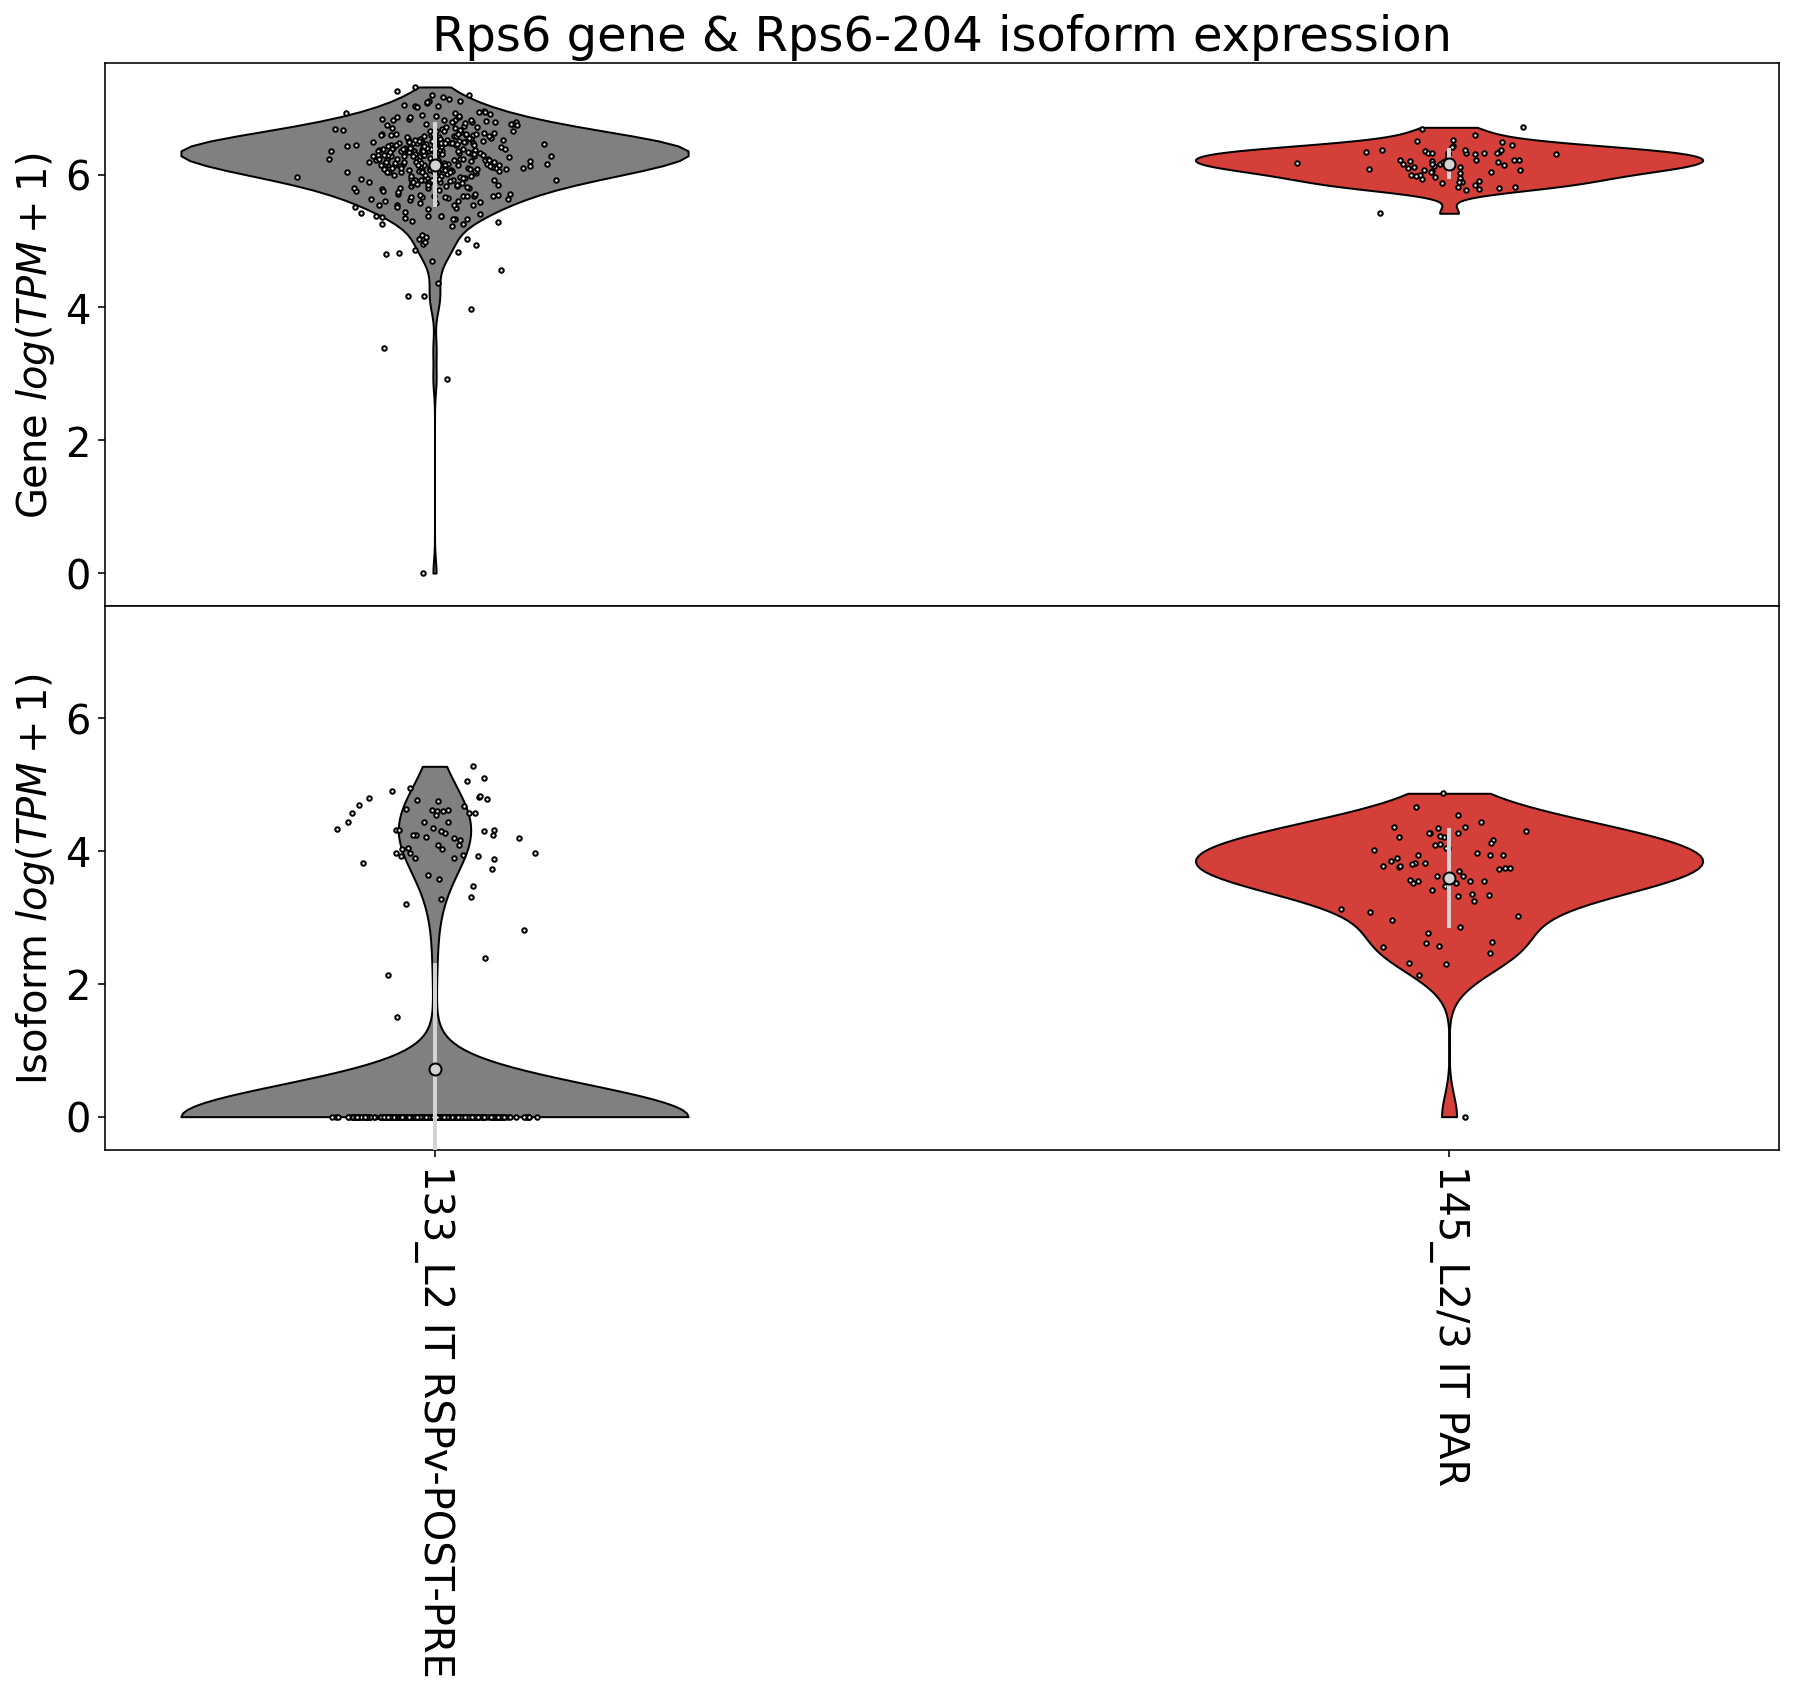

In [120]:
fig, ax = plt.subplots(figsize=(15,10), nrows=2, sharex=True)
fig.subplots_adjust(hspace=0, wspace=0)

# Declare
unique = np.unique(gene_f.obs.cluster_label)
unique = np.delete(unique, np.where(unique=="Low Quality"))
labels = unique
lidx = np.arange(1, len(labels)+1)  # the label locations
midx = np.where(unique==specific_cluster)[0][0]
plt.xticks(rotation=270)
## Plot
# Gene
x = []
for c in unique:
    #x.append(np.asarray(isoform_f[isoform_f.obs.cluster_label==c][:,isoform_f.var.transcript_name==specific_isoform].layers["log1p"].todense()).reshape(-1).tolist())
    x.append(np.asarray(gene_f[gene_f.obs.cluster_label==c][:,gene_f.var.gene_name==specific_gene].layers["log1p"].todense()).reshape(-1).tolist())
violinplot(x, ax[0], selected=midx)

# Isoform
x = []
for c in unique:
    x.append(np.asarray(isoform_f[isoform_f.obs.cluster_label==c][:,isoform_f.var.transcript_name==specific_isoform].layers["log1p"].todense()).reshape(-1).tolist())
violinplot(x, ax[1], selected=midx, xticks=lidx, xticklabels=labels)


## Style
ax[0].set(**{
    "title":"{} gene & {} isoform expression".format(specific_gene.split("_")[0], specific_isoform.split("_")[0]),
    "ylabel":"Gene $log(TPM + 1)$",
    "ylim": -0.5
})
ymin, ymax = ax[0].get_ylim()
ax[1].set(**{
    "ylabel":"Isoform $log(TPM + 1)$",
    "ylim": (ymin, ymax),
})


plt.savefig("../../../figures/cluster_DE_violin_{}.png".format(specific_gene.split("_")[0]), bbox_inches='tight',dpi=300)
plt.show()

In [121]:
from sklearn.neighbors import NeighborhoodComponentsAnalysis
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from matplotlib import cm

In [122]:
num_NCA = 5
state = 42
num_PCA = 10
num_TSNE = 2
metric = "euclidean"

In [123]:
X = gene_f.X

tsvd = TruncatedSVD(n_components=num_PCA)
Y = tsvd.fit_transform(X)

In [124]:
# NCA
X = Y
y = gene_f.obs.cluster_id.values.astype(int)

nca = NeighborhoodComponentsAnalysis(n_components=num_NCA,random_state=state)
YY = nca.fit_transform(X, y)

In [125]:
tsne = TSNE(n_components=num_TSNE, metric=metric, random_state=state)
YYY = tsne.fit_transform(YY)

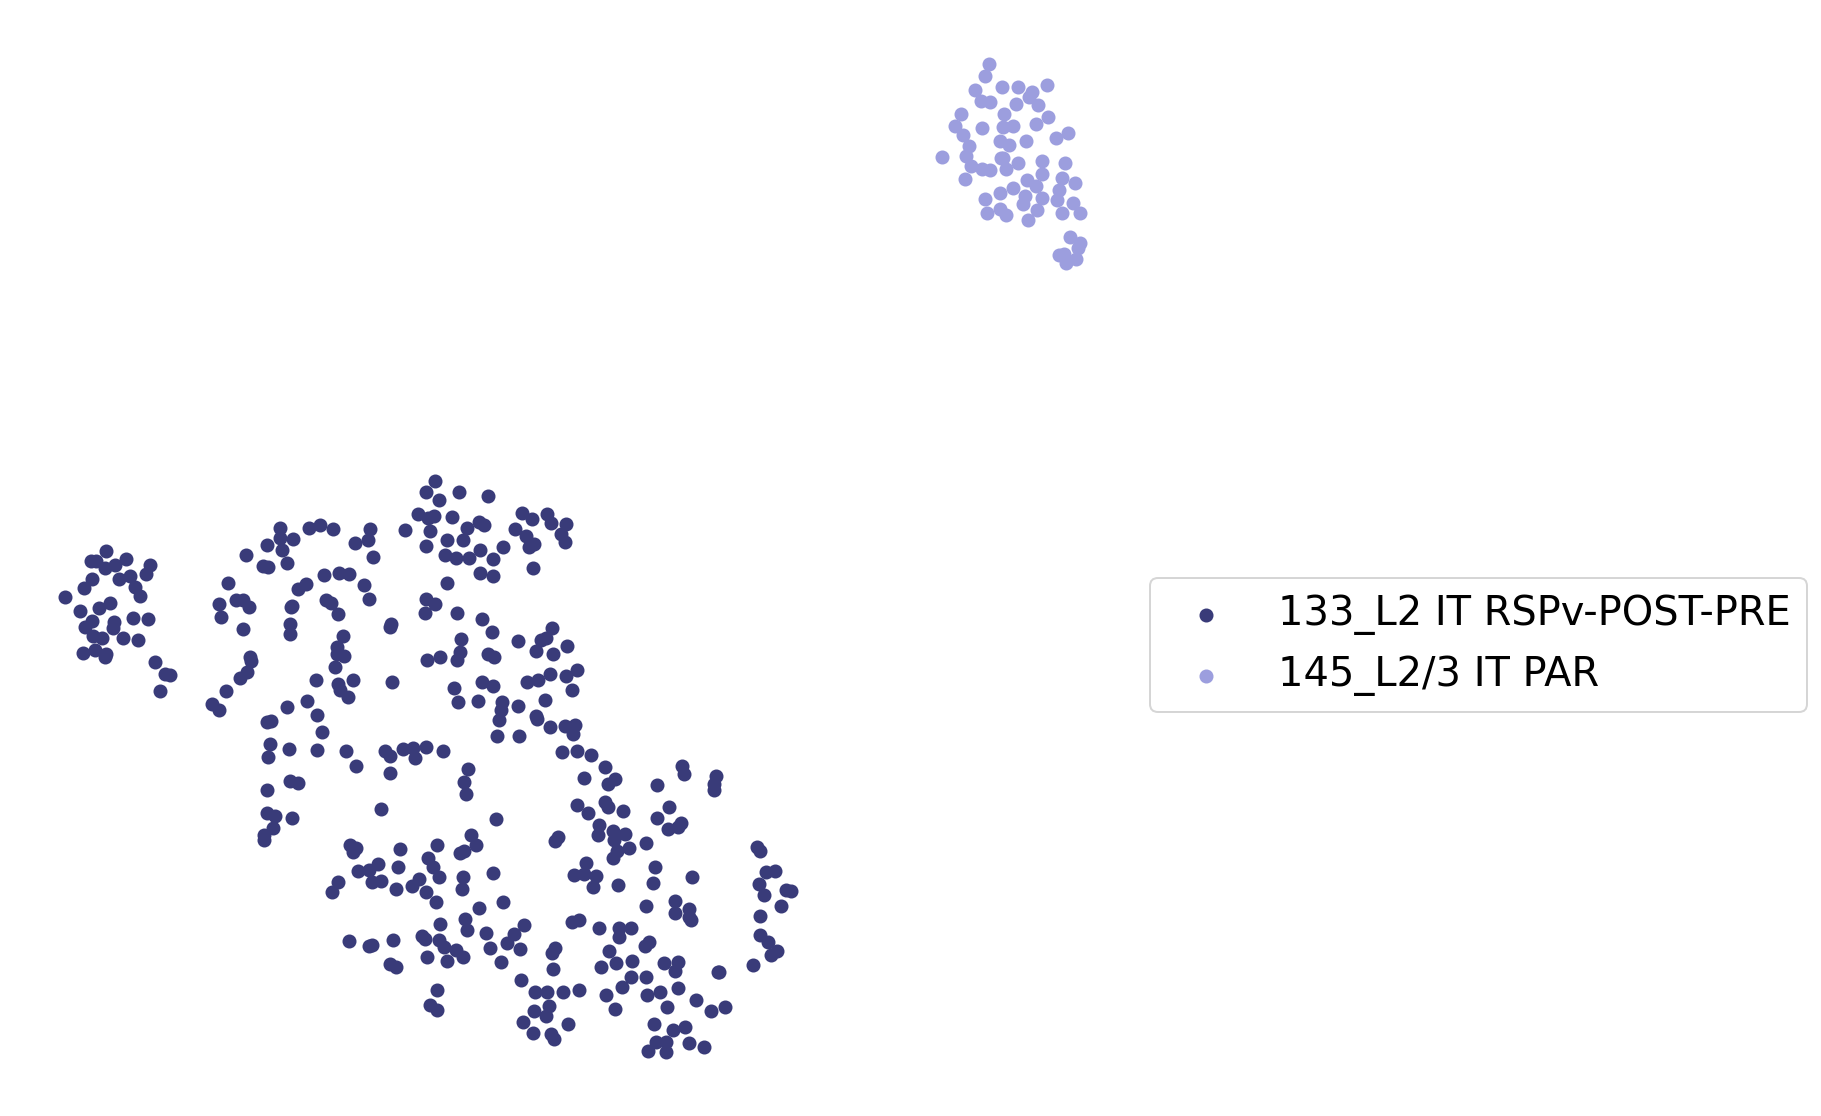

In [126]:
fig, ax = plt.subplots(figsize=(10,10))

x = YYY[:,0]
y = YYY[:,1]
c = cm.get_cmap("tab20b")
assignments = gene_f.obs.cluster_label.values
unique = np.unique(assignments)

for uidx, u in enumerate(unique):
    mask = assignments==u
    xx = x[mask]
    yy = y[mask]
    ax.scatter(xx, yy, color=c(uidx*3), cmap="tab20b", label=u)


ax.legend(bbox_to_anchor=(1, 0.5))

ax.set_axis_off()
plt.show()

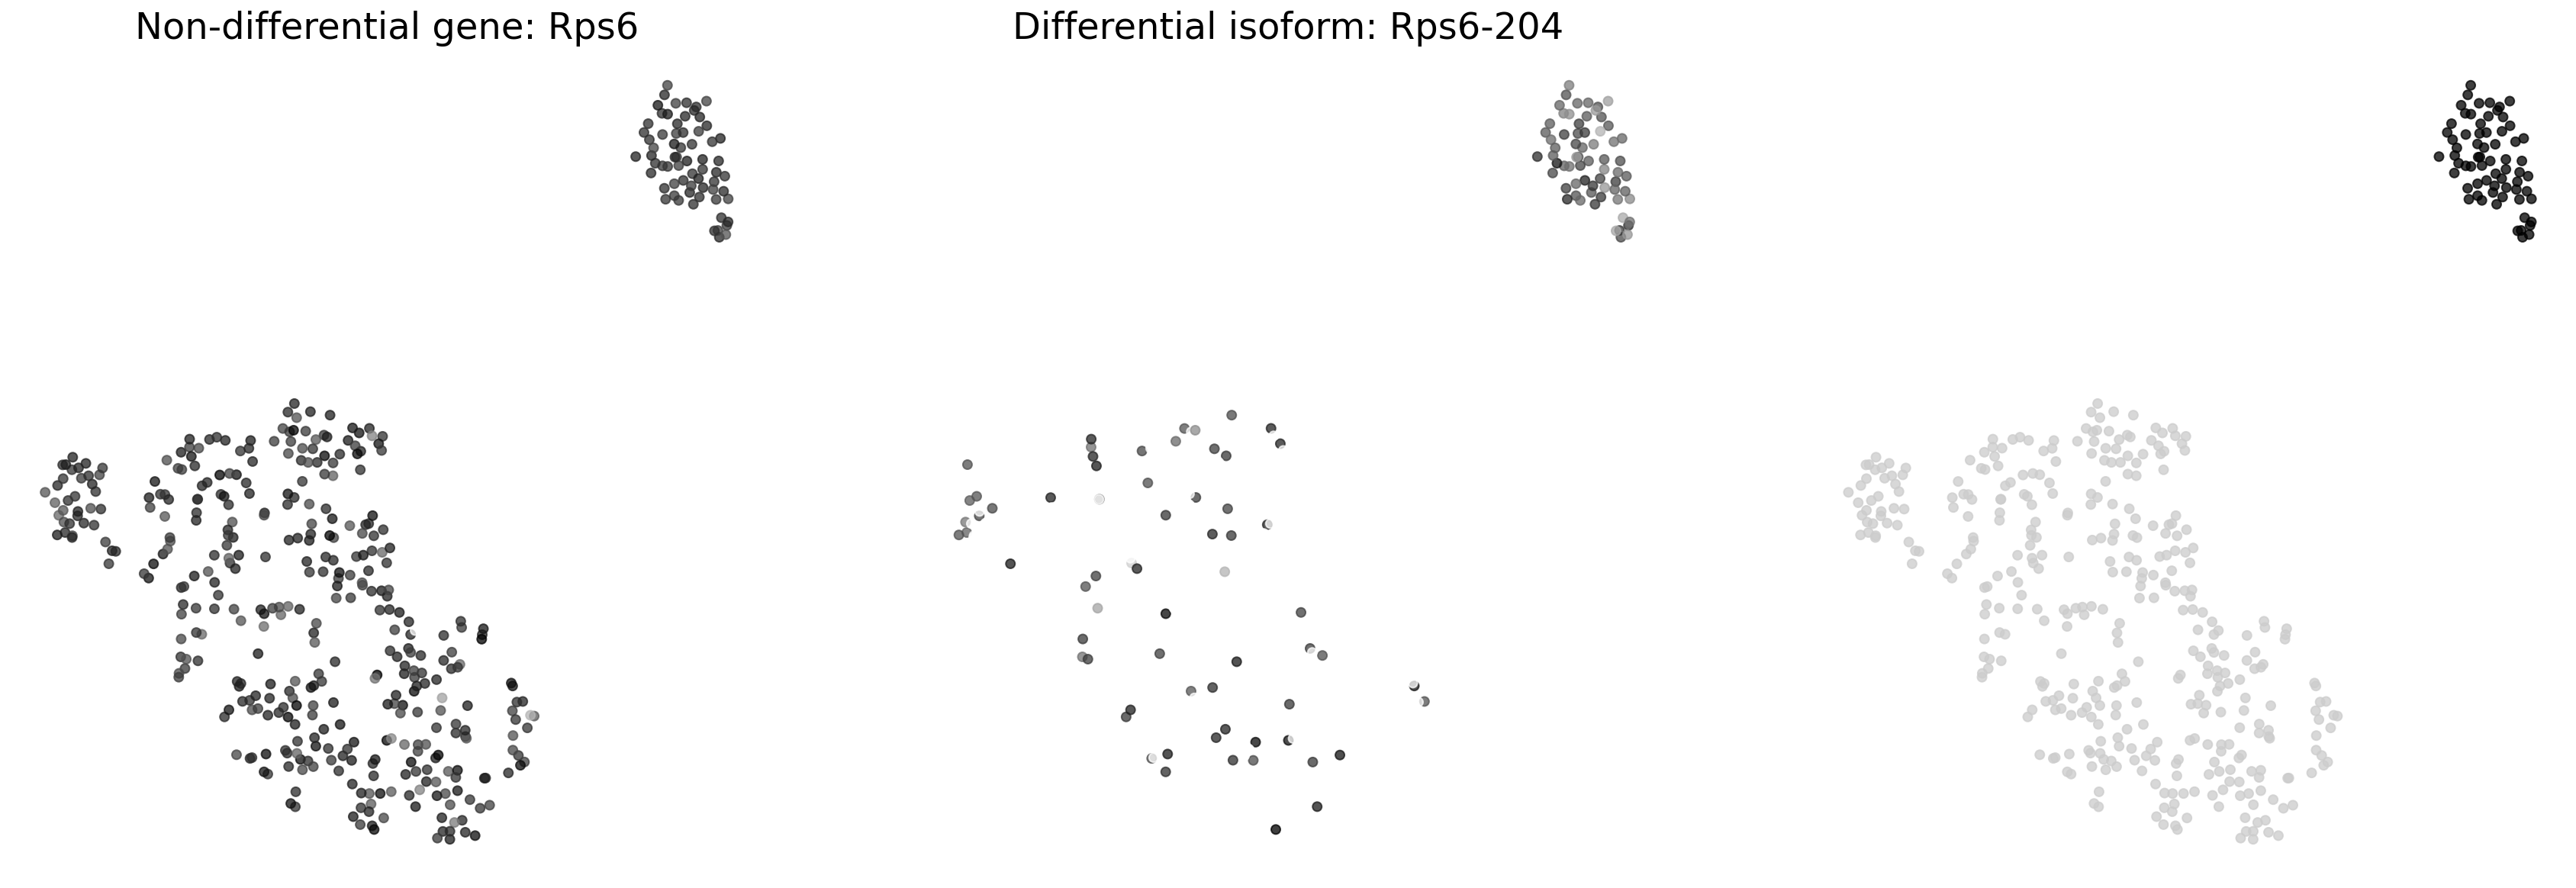

In [127]:
complement_color = (0.8, 0.8, 0.8, 1.0)

fig, ax = plt.subplots(figsize=(30,10), ncols=3)

x = YYY[:,0]
y = YYY[:,1]
c = np.asarray(gene_f[:, gene_f.var.gene_name==specific_gene].layers["log1p"].todense()).reshape(-1)
cmap="Greys"
alpha = 0.75
ax[0].set_title("Non-differential gene: {}".format(specific_gene.split("_")[0]))

ax[0].scatter(x, y, c=c, cmap=cmap, alpha=alpha)
ax[0].set_axis_off()


x = YYY[:,0]
y = YYY[:,1]
c = np.asarray(isoform_f[:, isoform_f.var.transcript_name==specific_isoform].layers["log1p"].todense()).reshape(-1)
cmap="Greys"
alpha = 0.75
ax[1].set_title("Differential isoform: {}".format(specific_isoform.split("_")[0]))

ax[1].scatter(x, y, c=c, cmap=cmap, alpha=alpha)
ax[1].set_axis_off()

x = YYY[:,0]
y = YYY[:,1]

c = gene_f.obs["cluster_id"].values.astype(int)
c = gene_f.obs["cluster_label"]==specific_cluster

alpha=0.75
cmap="nipy_spectral_r"

ax[2].scatter(x, y, c=c, cmap=cmap, alpha=alpha)

ax[2].set_axis_off()
#ax[2].set_title("Cluster: {}".format(specific_cluster))
plt.savefig("../../../figures/cluster_DE_nca_{}.png".format(specific_gene.split("_")[0]), bbox_inches='tight',dpi=300)
plt.show()